Goal: Find predictors of season length
#### todo:
* multiple kernal gp
* create multi-output regression on season start/stop  
* add features:  
    * snowfall by month -> fit to normal dist -> extract st.dev : only winter vs fall&spring snow

# Imports and setup


In [15]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from scipy import stats
from tqdm import tqdm
import json
from pandas import json_normalize
import re
from itertools import cycle

import matplotlib.pyplot as plt
import seaborn as sns

#model zoo
from sklearn.linear_model import ElasticNet, BayesianRidge, lasso_path, enet_path
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor as GradBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor as GPRegressor

#model selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance

In [16]:
# pip installing pymc3 'works' but pymc3 isn't importable. this works.

from pip._internal import main
try:
    import pymc3 as pm
except:
    from pip._internal import main
    main(['install', 'pymc3'])
    import pymc3 as pm
import pymc3

## Notebook Setup

In [18]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

# Data Loading & Cleaning

In [19]:
def name_cleaner(data: pd.Series=None) -> pd.Series:
    """cleans names to facilitate merge op"""
    
    data = data.str.strip()
    # words/phrases to remove
    remove = ["Ski Area", "Ski Resort", "Mountain Resort", "Resort", 
             "\(Ski and Snowboard Resort\)", "\(Colorado\)", "Ski Tahoe",
             "\(Ski and Snowboard \)", "Mountain$", "'", "-", "The", "^Ski",
             "Creek$", "^Tahoe", "Ski Ranch$"]
    reg_to_del = [re.compile(r, re.IGNORECASE) for r in remove]
    
    for reg in reg_to_del:
        data = data.str.replace(pat=reg, repl="", regex=True)
    
    # replace with full words
    re_mount = re.compile("Mt.", re.IGNORECASE)
    data = data.str.replace(re_mount, repl="Mount")
    
    # add missing space between words
    data = data.str.replace("[a-z](?=[ABD-Z])",
                           lambda m: m.group(0) + " ")
    return data.str.strip()

In [20]:
# Load Data
data_paths = dict(
    betas = r"../../data/processed/snow_betas.parquet",
    stan_betas = r"../../data/processed/stan_betas.parquet",
    path_season_length = r"../../data/processed/season_length.parquet",
    stations_path = r"../../data/processed/stationswki.parquet")


betas_df = pd.read_parquet(data_paths['betas'])
stan_betas = pd.read_parque(data_paths['stan_betas'])
season_length_df = pd.read_parquet(data_paths['path_season_length'])
stations_df = pd.read_parquet(data_paths['stations_path'])

In [21]:
stations_df['name'] = name_cleaner(stations_df.name)
betas_df.index = name_cleaner(betas_df.index)
season_length_df['station'] = name_cleaner(season_length_df.station)

In [22]:
betas_df = betas_df.drop(columns=["station", "region"]).rename_axis('station')

In [23]:
season_length_avg_df = (season_length_df
                        .groupby(['station', 'region'])
                        [['length']]
                        .mean()
                        .reset_index()
                       )

In [24]:
all_names = pd.merge(left=stations_df, right=betas_df,
                     left_on="name", right_index=True,
                     how='outer')

In [25]:
complete_df = (pd.merge(left=stations_df, right=betas_df,
                        left_on="name", right_index=True)
               .merge(right=season_length_avg_df, left_on='name', right_on='station')
               .drop(columns=['region_y', 'total_lifts', 'state_province', 'name'])
               .rename(columns={'region_x': 'region', 'length': 'season_len'})
               .set_index('station')
               .pipe(pd.get_dummies, columns=['region'])
                    )
complete_df.head()

,peak_elevation_ft,base_elevation_ft,skiable_acreage,avg_annual_snowfall_in,avg_elevation_ft,beta,season_len,region_Cascades,region_Colorado,region_East,region_Sierras,region_Utah
station,,,,,,,,,,,,
Mount Hood Skibowl,5027.0,3500.0,960.0,300.0,4263.5,-0.120706,132.777778,1,0,0,0,0
Spout Springs,5450.0,4920.0,200.0,130.0,5185.0,0.185223,91.500000,1,0,0,0,0
Hoodoo,5703.0,4668.0,806.0,360.0,5185.5,0.817764,130.222222,1,0,0,0,0
Willamette Pass,6683.0,5120.0,555.0,430.0,5901.5,0.043802,124.125000,1,0,0,0,0
Mount Hood Meadows,7300.0,4523.0,2150.0,430.0,5911.5,-0.041304,175.555556,1,0,0,0,0


In [26]:
train, test = train_test_split(complete_df, test_size=.8)

def xy_split(data=None, ycol='season_len'):
    return (data.copy().drop(columns=[ycol]).to_numpy(),
            data.copy()[[ycol]].to_numpy().reshape(-1))

X, y = xy_split(complete_df)
X_train, y_train = xy_split(train)
X_test, y_test = xy_split(test)

## Regression

### Feature work

In [27]:
ProfileReport(complete_df)

# Modeling
The data set size is _probably_ large enough that nested CV isn't necessary; however it is a best practice and the training time isn't that big so I will use it.
### Naive Model

In [28]:
y_mean = y_train.mean()
naive_mae = np.mean(np.abs(y_test-y_mean))
naive_mse = (np.mean((y_test - y_mean)**2))
print(f"""Naive Model mean square error: {naive_mse}
Naive Model Mean Absolute Error: {naive_mae}""")

Naive Model mean square error: 921.9053360995814
Naive Model Mean Absolute Error: 23.404305055355476


In [29]:
# Algos
linear = ElasticNet()
rforest = RandomForestRegressor()
gboost = GradBoostRegressor()
knn =  KNeighborsRegressor()
svm = SVR()
gp = GPRegressor()
models = ['linear', 'rforest', 'gboost', 'knn', 'svm',]

In [30]:
params = {}
params['linear'] = {'clf__alpha': stats.uniform(.0001, 100),
                    'clf__l1_ratio': stats.uniform(.1, .9)}
params['rforest'] = {'clf__criterion': ('mse', 'mae'),
                     'clf__max_features': ('log2', 'sqrt', .2, .15),  
                     'clf__max_depth': (5, 15, 30),
                     'clf__min_samples_split': (10, 20, 30)}
params['gboost'] = {'clf__learning_rate': stats.uniform(.08, .12),
                    'clf__n_estimators': (80, 100, 120,)}
params['knn'] = {'clf__n_neighbors': (3, 5, 7),
                 'clf__weights': ('uniform', 'distance'),
                 'clf__p': (1.5, 2, 2.5)}
params['svm'] = {'clf__C': (.4, .7, 1, 1.3, 2, 10),
                 'clf__epsilon': (.001, .01, .1), 
                 'clf__kernel': ('linear', 'poly', 'rbf')}

In [31]:
cv_scores_df = pd.DataFrame()
for model in tqdm(models):
    
    # build cv model with params to search for best model
    estimator = Pipeline(steps=[('scaler', StandardScaler()), 
                                ('clf', eval(model))])
    cv_object = RandomizedSearchCV(estimator=estimator,
                                   param_distributions=params[model], 
                                   n_iter=20, cv=5, error_score='raise',
                                   return_train_score=True, refit='neg_mean_squared_error')
    
    # CV to get unbiased estimate of model performance
    scores = cross_validate(estimator=cv_object, scoring=['r2', 'neg_mean_absolute_error', 
                                                          'neg_mean_squared_error'],
                            X=X_train, y=y_train,
                            cv=5, n_jobs=1, return_estimator=True,
                            return_train_score=True)
    
    # find best model params
    cv_object.fit(X, y)
    best_model = cv_object.best_estimator_
    
    # unpack results from inner loop TODO: add stdev of scores
    cv_scores_df.loc[model, "best_estimator"] = best_model
    cv_scores_df.loc[model, "test_mae"] = -np.mean(scores['test_neg_mean_absolute_error'])
    cv_scores_df.loc[model, "test_mae_std"] = np.std(scores['test_neg_mean_absolute_error'])
    
    cv_scores_df.loc[model, "test_mse"] = -np.mean(scores['test_neg_mean_squared_error'])
    cv_scores_df.loc[model, "test_mse_std"] = np.std(scores['test_neg_mean_squared_error'])

    cv_scores_df.loc[model, "test_r2"] = -np.mean(scores['test_r2'])
    cv_scores_df.loc[model, "test_r2_std"] = np.std(scores['test_r2'])

 60%|█████████████████████████████████████████████████████▍                                   | 3/5 [01:38<00:45, 22.75s/it]c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, se

In [32]:
cv_scores_df.loc["naive_model", "test_mse"] = naive_mse
cv_scores_df.loc["naive_model", "test_mae"] = naive_mae

In [33]:
cv_scores_df.sort_values('test_mse', ascending=True).round(2)

,best_estimator,test_mae,test_mae_std,test_mse,test_mse_std,test_r2,test_r2_std
linear,"(StandardScaler(), ElasticNet(alpha=2.81138758...",20.60,11.65,849.32,966.27,0.54,0.85
svm,"(StandardScaler(), SVR(C=10, epsilon=0.001, ke...",22.54,9.57,868.89,809.03,1.37,1.44
naive_model,NaN,23.40,NaN,921.91,NaN,NaN,NaN
knn,"(StandardScaler(), KNeighborsRegressor())",26.56,9.66,1301.41,983.71,6.15,9.72
rforest,"(StandardScaler(), (DecisionTreeRegressor(crit...",29.69,9.31,1444.75,1182.73,4.05,3.85
gboost,"(StandardScaler(), ([DecisionTreeRegressor(cri...",28.48,20.76,1571.11,1814.17,2.55,3.52


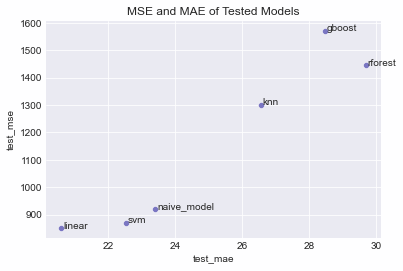

In [34]:
ax = sns.scatterplot(data=cv_scores_df, x='test_mae', y='test_mse')
for txt in cv_scores_df.index:
    x, y_ = cv_scores_df.loc[txt, ['test_mae', 'test_mse']]
    ax.annotate(txt, (x+.05, y_+.05))
ax.set_title("MSE and MAE of Tested Models");

In [19]:
best_model_cv = RandomizedSearchCV(estimator=gboost,
                                   param_distributions={
                                       k.replace("clf__", ""): v 
                                       for k, v in params['gboost'].items()
                                                       }, 
                                   n_iter=4, cv=5, error_score='raise',
                                   return_train_score=True, refit='neg_mean_squared_error')
best_model_cv.fit(X_train, y_train)
best_model = best_model_cv.best_estimator_
best_model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.09569228391715129,
                          loss='ls', max_depth=3, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=80, n_iter_no_change=None,
                          presort='deprecated', random_state=None,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [20]:
features = complete_df.drop(columns="season_len").columns.to_list()
feature_importance = (pd.DataFrame(data=best_model.feature_importances_, index=features,
                                      columns=['importance'])
                      .sort_values(by='importance', ascending=False)
                      .rename_axis("feature", axis="index")
                      .reset_index())
pi_data = {k: v for k, v in permutation_importance(best_model, X_test, y_test).items()
           if k not in ['importances']}
permu_importance = (pd.DataFrame(data=pi_data, index=features)
                   .sort_values(by='importances_mean', ascending=False)
                   .round(3)
                   .rename(columns={'importances_mean': 'importance'})
                   .rename_axis("feature", axis='index')
                   .reset_index())

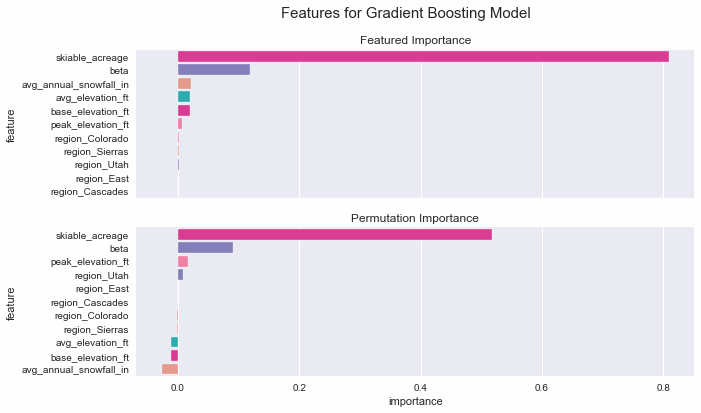

In [21]:
figimp, aximp = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# sync colors for features
feat_set = set([*permu_importance.feature.unique(),
                *feature_importance.feature.unique()])
pal = {a: b for a, b
       in zip(feat_set, sns.color_palette(n_colors=len(feat_set)))}

sns.barplot(data=feature_importance,
            y='feature', x='importance',
            orient='h', ax=aximp[0], palette=pal)
aximp[1] = sns.barplot(data=permu_importance, x='importance', y='feature',
                       palette=pal)
figimp.suptitle("Features for Gradient Boosting Model", fontsize=15)
aximp[0].set(title='Featured Importance')
aximp[1].set(title='Permutation Importance')
# get axis that include negatives and maximum of both
maxx = max(xaxis.get_xlim()[1] for xaxis in aximp)
aximp[0].set_xlim(aximp[1].get_xlim()[0], maxx)
aximp[0].set_xlabel("")

# plt.savefig('../../resources/feat_importance.png')
plt.show()

##### Analysis
Skiable acreage being important is interesting, perhaps larger resorts are better able to include enough north-facing or other subareas that can mainatin snow for a long time. Annual snowfall obviously would influence season length. After working on the time series data for a while, I'm glad beta - the regression with SARIMA errors coefficient indicating how much base results from an inch of snowfall - made it into the top three!

## Detailed Modeling
Handcrafted models
### Linear Model

Assumptions for Linear Regression and Implications if model fails:
* Linearity in the terms: Model Not Specified Correctly/Not a linear model
* Error term has mean of zero: Model not specified correctly; biased estimates
* No perfect Co-linearity:
    * May not be able to solve for _X_<sup>T</sup>X
    * Larger standard error for affected predictor variables
    * unstable estimates of coefficients of affected variables
* homoscedasticity (spherical error variance): t/F tests not valid
* Error terms uncorrleated: Omitted variable, use time-series methods
* Exogeneity (no correlation of predictors and error term): 
    * biased/inconsistant estimates; omitted variable, use advanced methods  

Non-assumption:
* Normality of errors: Omitted variable bias; 


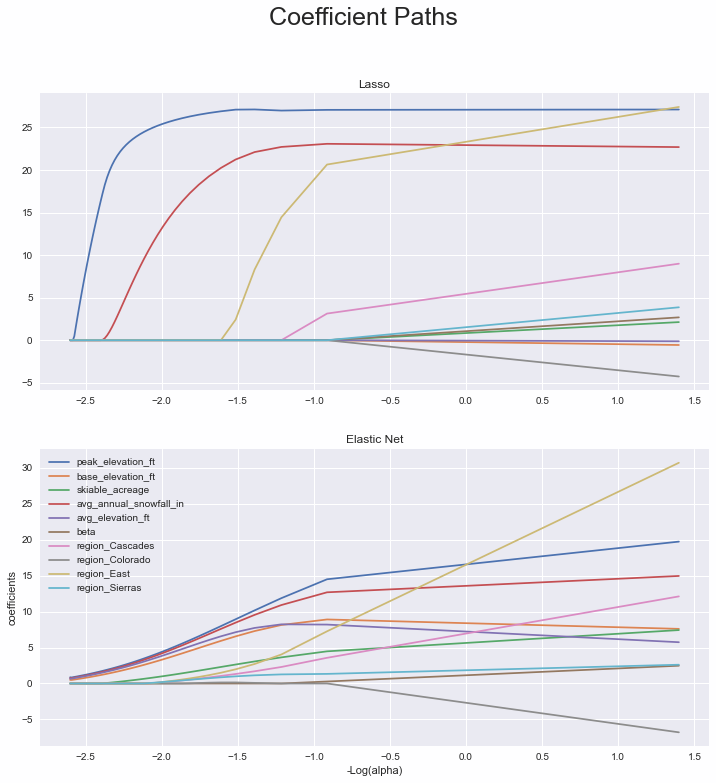

In [22]:
X /= X.std(axis=0)
eps = 4e-5  # the smaller it is the longer is the path
alphas = np.linspace(4e-2, 4e2, num=50)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, alphas=alphas,
                                          fit_intercept=False, tol=10)
alphas_enet, coefs_enet, _ = enet_path(X, y, alphas=alphas,
                                       fit_intercept=False, tol=10)
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
colors = sns.color_palette("deep")
features = complete_df.drop(columns=['season_len']).columns

fig, ax = plt.subplots(2, 1, figsize=(12, 12))


for coef_l, coef_e, c, feature in zip(coefs_lasso, coefs_enet, colors, features):
    ax[0].plot(neg_log_alphas_lasso, coef_l, c=c, label=feature)
    ax[1].plot(neg_log_alphas_enet, coef_e, c=c, label=feature)
    plt.legend(loc=2, shadow=True)
    fig.suptitle("Coefficient Paths",
                fontsize=25)
    ax[0].set_title('Lasso', fontsize=12)
    ax[1].set_title('Elastic Net', fontsize=12)
    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    ax[1].set_ylabel('coefficients')
    plt.axis('tight')
plt.savefig('../../resources/coef_paths.png')


Add Interactions based on tree models

## Gaussian Process
GP uses some nice properties of normal distributions (marginalized dist is also gaussian) to model distributions over functions and write a model as a mean function and covariance function, and use various fuctions (including sums of useful functions) for these.

#### Categorical Dimensions
To deal with categorical data, I have already one-hot encoded the categories. I will use squared exponential kernals on each new feature, and multiply all these tother.

In [48]:
categorical_features = [c for c in complete_df.columns 
                        if c in complete_df.dtypes[complete_df.dtypes=="uint8"].index]
cont_features = [c for c in complete_df.columns 
                 if c not in categorical_features if c not in 'season_len']  # don't inc Y

['peak_elevation_ft',
 'base_elevation_ft',
 'skiable_acreage',
 'avg_annual_snowfall_in',
 'avg_elevation_ft',
 'beta']

#### Estimating latent function

In [ ]:
with pm.Model() as gp_model_latent:
    ## categoricals
    # Lengthscale
    ρ = []
    for i, _ in enumerate(categorical_features):
        ρ.append(pm.HalfCauchy(f'ρ_{i}', 5))
    # covariance func
    cat_cov_func = pm.gp.cov.ExpQuad(input_dim=len(ρ), ls=ρ)

    c = pm.Normal("cont_cov_c")
    cont_cov_func = pm.gp.cov.Linear(input_dim=len(cont_features), c=c)
    
    σ = pm.HalfCauchy('σ', 2.5)
    cov_func = cat_cov_func + cont_cov_func
    
    gp = pm.gp.Marginal(cov_func=cat_cov_func)
    y_hat = gp.marginal_likelihood("y", X=X, y=y, noise=σ)
    
with gp_model_latent:
    trace = pm.sample(2000)


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\pymc3\gp\cov.py:97: UserWarning: Only 5 column(s) out of 11 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  UserWarning,


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, cont_cov_c, ρ_4, ρ_3, ρ_2, ρ_1, ρ_0]


#### Prediction

### Error Analysis
#### Gradient Boosting

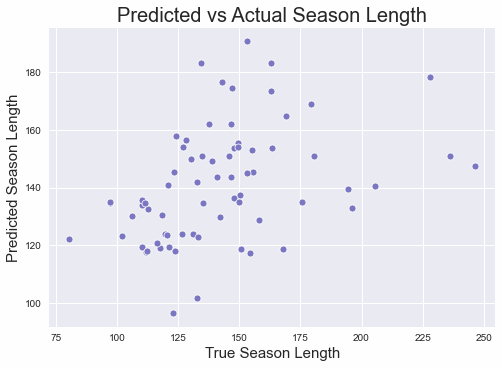

In [23]:
unseen_predicts = best_model.fit(X_train, y_train).predict(X_test)
ax = sns.scatterplot(x=y_test, y=unseen_predicts)
plt.title("Predicted vs Actual Season Length", size=20)
ax.set_xlabel("True Season Length", size=15)
ax.set_ylabel("Predicted Season Length", size=15);

Bayesian Search ## todo

In [ ]:
from skopt import BayesSearchCV
# define search space
params = dict()
params['C'] = (1e-6, 100.0, 'log-uniform')
params['gamma'] = (1e-6, 100.0, 'log-uniform')
params['degree'] = (1,5)
params['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the search
search = BayesSearchCV(estimator=SVC(), search_spaces=params, n_jobs=-1, cv=cv)
# perform the search
search.fit(X, y)
# report the best result
print(search.best_score_)
print(search.best_params_)